<a href="https://colab.research.google.com/github/gabychoi/comment-clean-bot/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import glob
import re

from tqdm import tqdm_notebook

In [4]:
# 크롤링한 전체 댓글 데이터 불러오기
raw_data = pd.read_csv('/content/gdrive/My Drive/eda_data/repl_data.csv')

# 전체 데이터 개수
len(raw_data)

127125

In [5]:
# 중복 댓글 제거
repl_data = raw_data.drop_duplicates(subset='댓글', keep='first', inplace=False)

# 결측치 제거
repl_data = repl_data.loc[repl_data['댓글'].notnull(), ]

# 중복&결측치 제거 데이터 개수
len(repl_data)

118999

In [6]:
# 정규표현식 전과 후를 비교하기 위해 세로운 데이터프레임 생성
preprocessing_df = repl_data.copy()
preprocessing_df.head()

,Unnamed: 0,Unnamed: 0.1,댓글,출처
0,0,0,🗣,./data\JTBCNEWS_인스타_댓글_1116.csv
1,1,1,"심각허다,, 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받...",./data\JTBCNEWS_인스타_댓글_1116.csv
2,2,2,"차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도, 차도...",./data\JTBCNEWS_인스타_댓글_1116.csv
3,3,3,국회의원직 다 박탈했으면 좋겠네ㅠㅠ,./data\JTBCNEWS_인스타_댓글_1116.csv
4,4,4,표 얻을 생각 말고 법을 만들어라,./data\JTBCNEWS_인스타_댓글_1116.csv


In [7]:
# @[아이디] 제거
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('@[a-zA-Z가-힣\w\.\_\d]+', '')


In [8]:
# 한글/영어/숫자를 제외한 문자제거 : 이모티콘이나 특수문자를 제거한다
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('[^a-zA-Z가-힣0-9ㄱ-ㅎㅏ-ㅣ\s]', '')
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('\s[\s*]', '')

In [9]:
# 양 옆 빈 공백 제거
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.rstrip()
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.lstrip()

In [10]:
# 빈댓글 제거
preprocessing_df = preprocessing_df[preprocessing_df['댓글'] != '']
preprocessing_df = preprocessing_df[preprocessing_df['댓글'] != ' ']

In [11]:
# 영어만 있는 행 제거
preprocessing_df = preprocessing_df['댓글']

In [12]:
comment_df = pd.DataFrame(preprocessing_df)
comment_df['댓글'].str.lower()

1         심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...
2         차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...
3                                       국회의원직 다 박탈했으면 좋겠네ㅠㅠ
4                                        표 얻을 생각 말고 법을 만들어라
5                              초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네
                                ...                        
127118                                              오빠 어디예요
127119                                               외국 갔어요
127121                                 이건 홍마담에서 구입 못하나요 ㅎㅎㅎ
127122                                           느무 잘먹는 예 9
127123                               맛있는건 눈으로만 봐도 알죠맛있게 드세요
Name: 댓글, Length: 109635, dtype: object

In [13]:
preprocessing_df = comment_df[~comment_df['댓글'].str.isalpha()]

In [14]:
preprocessing_df.shape

(92063, 1)

**악성단어 뭉치 필터링 - 라벨2**

In [15]:
preprocessing_df['악플여부'] = np.NaN
preprocessing_df.head()

,댓글,악플여부
1,심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...,NaN
2,차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...,NaN
3,국회의원직 다 박탈했으면 좋겠네ㅠㅠ,NaN
4,표 얻을 생각 말고 법을 만들어라,NaN
5,초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네,NaN


In [16]:
filter_word_df = pd.read_excel('/content/gdrive/My Drive/eda_data/필터링단어.xlsx')

In [17]:
filter_word_df.shape[1]

13

In [18]:
for col in tqdm_notebook(range(filter_word_df.shape[1])):
    word_list = list(filter_word_df.iloc[:, col])[0].split(', ')
    label = filter_word_df.columns[col][-2]

    for filter_word in tqdm_notebook(word_list):
        preprocessing_df.loc[ preprocessing_df['댓글'].str.match('.*' + filter_word + '.*'), '악플여부' ] = label

In [19]:
preprocessing_df
preprocessing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92063 entries, 1 to 127123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   댓글      92063 non-null  object
 1   악플여부    8856 non-null   object
dtypes: object(2)
memory usage: 2.1+ MB


In [20]:
# 악플 필터링된 개수 확인
preprocessing_df.fillna(0,  inplace=True)
word_label = preprocessing_df.groupby(['악플여부']).size()
word_label_df = pd.DataFrame(word_label)
word_label_df.columns = ['개수']
word_label_df.head()

,개수
악플여부,
0,83207
2,8856


**[가은]악플 필터링/노필터링 워드클라우드**

In [22]:
# 댓글길이 컬럼 추가 및 최대길이 확인
preprocessing_df['댓글길이'] = preprocessing_df['댓글'].apply(lambda x : len(str(x)))
preprocessing_df['댓글길이'].max()

1978

In [23]:
# 댓글길이 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [24]:
len_int = preprocessing_df['댓글길이'].astype(int)
len_sort = len_int.sort_values()
sort_df = pd.DataFrame(len_sort)

len_count = pd.DataFrame(sort_df.groupby(['댓글길이']).size())
len_count.columns = ['댓글개수']
len_count

,댓글개수
댓글길이,
1,19
2,56
3,148
4,515
5,1445
...,...
1812,1
1846,1
1921,1


In [25]:
len_count.reset_index(level=0, inplace=True)

In [26]:
len_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   댓글길이    739 non-null    int64
 1   댓글개수    739 non-null    int64
dtypes: int64(2)
memory usage: 11.7 KB


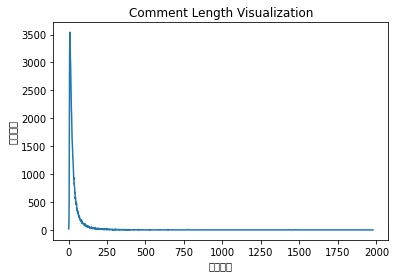

In [27]:
plt.title('Comment Length Visualization')
plt.plot(len_count['댓글길이'], len_count['댓글개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

In [28]:
# 댓글길이 500자 이하
len_count2 = len_count[len_count['댓글길이'] <= 500]
len_count2

,댓글길이,댓글개수
0,1,19
1,2,56
2,3,148
3,4,515
4,5,1445
...,...,...
475,495,1
476,496,1
477,497,2
478,499,1


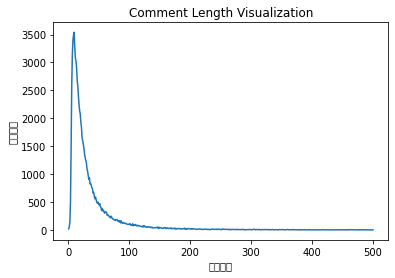

In [29]:
plt.title('Comment Length Visualization')
plt.plot(len_count2['댓글길이'], len_count2['댓글개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

In [30]:
# 댓글길이 200 이상 1000자 이하
len_count3 = len_count[(len_count['댓글길이'] <= 1000) & (len_count['댓글길이'] >= 200)]
len_count3

,댓글길이,댓글개수
199,200,18
200,201,19
201,202,24
202,203,12
203,204,22
...,...,...
705,952,2
706,955,1
707,958,1
708,960,1


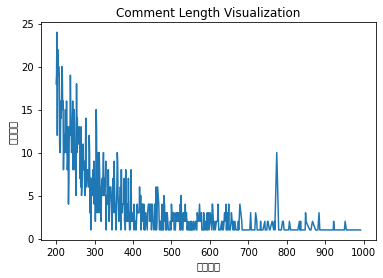

In [47]:
plt.title('Comment Length Visualization')
plt.plot(len_count3['댓글길이'], len_count3['댓글개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

**-------  일단 여기 아래로부터는 안 봐도 돼! 가은아**

In [32]:
# 악플 라벨링된 데이터
bad_comment = preprocessing_df[preprocessing_df['악플여부'] == '2']
bad_comment.head()

,댓글,악플여부,댓글길이
103,지랄을 한다 역격리 고맙다,2,14
119,지네때문에 온나라가 지랄낫는데,2,16
130,짱꺄나 쪽바리나,2,8
174,지랄한다미세먼지나 잡아라 중국에 말도 못하면서 말은 잘도 씨부린다,2,36
256,아무리 내새끼라도 다리병신 만들어버렸을듯,2,22


In [33]:
# 악플 데이터 길이 확인
bad_comment['댓글길이'] = bad_comment['댓글'].apply(lambda x : len(str(x)))

In [34]:
bad_len = bad_comment[bad_comment['댓글길이'] <= 500]
bad_len['댓글길이'].max()

500

In [35]:
# 댓글 길이 확인
preprocessing_df['댓글길이'] = preprocessing_df['댓글'].apply(lambda x : len(str(x)))

preprocessing_df['댓글길이'].max()

1978

In [36]:
# 댓글길이 시각화

import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
len_int = preprocessing_df['댓글길이'].astype(int)
len_sort = len_int.sort_values()
sort_df = pd.DataFrame(len_sort)

len_count = pd.DataFrame(sort_df.groupby(['댓글길이']).size())
len_count.columns = ['댓글개수']
len_count



,댓글개수
댓글길이,
1,19
2,56
3,148
4,515
5,1445
...,...
1812,1
1846,1
1921,1


In [38]:
len_count.reset_index(level=0, inplace=True)

In [39]:
len_count

,댓글길이,댓글개수
0,1,19
1,2,56
2,3,148
3,4,515
4,5,1445
...,...,...
734,1812,1
735,1846,1
736,1921,1
737,1945,1


In [40]:
# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

Unknown system... sorry~~~~


In [41]:
import matplotlib as mpl
%matplotlib inline

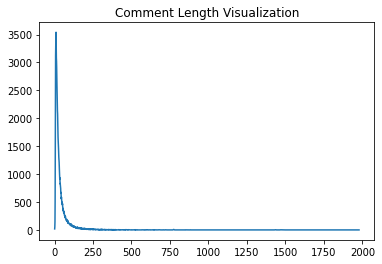

In [42]:
plt.title('Comment Length Visualization')
plt.plot(len_count['댓글길이'], len_count['댓글개수']) #앞이 x축, 뒤가 y축
# plt.xlabel('댓글길이')
# plt.ylabel('댓글개수')
plt.show()

In [43]:
len_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   댓글길이    739 non-null    int64
 1   댓글개수    739 non-null    int64
dtypes: int64(2)
memory usage: 11.7 KB


In [44]:
repl_data

,Unnamed: 0,Unnamed: 0.1,댓글,출처
0,0,0,🗣,./data\JTBCNEWS_인스타_댓글_1116.csv
1,1,1,"심각허다,, 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받...",./data\JTBCNEWS_인스타_댓글_1116.csv
2,2,2,"차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도, 차도...",./data\JTBCNEWS_인스타_댓글_1116.csv
3,3,3,국회의원직 다 박탈했으면 좋겠네ㅠㅠ,./data\JTBCNEWS_인스타_댓글_1116.csv
4,4,4,표 얻을 생각 말고 법을 만들어라,./data\JTBCNEWS_인스타_댓글_1116.csv
...,...,...,...,...
127120,968,968,🇧🇻🇰🇷❤️❤️❤️,./data\홍석천.csv
127121,969,969,이건... 홍마담에서 구입 못하나요? ㅎㅎㅎ,./data\홍석천.csv
127122,970,970,느무 잘먹는 예 9,./data\홍석천.csv
127123,971,971,"맛있는건 눈으로만 봐도 알죠,맛있게 드세요",./data\홍석천.csv


In [45]:
# 댓글길이 300이상 500이하
repl_data = repl_data[(repl_data['댓글길이'] <= 500) & (repl_data['댓글길이'] >= 300)]
repl_data

KeyError: ignored

In [ ]:
len_int = repl_data['댓글길이'].astype(int)
len_sort = len_int.sort_values()
sort_df = pd.DataFrame(len_sort)

len_count = pd.DataFrame(sort_df.groupby(['댓글길이']).size())
len_count.columns = ['댓글개수']
len_count


In [ ]:
len_count.reset_index(level=0, inplace=True)

In [ ]:
len_count.head()

In [ ]:
plt.title('Comment Length Visualization')
plt.plot(len_count['댓글길이'], len_count['댓글개수']) #앞이 x축, 뒤가 y축
# plt.xlabel('댓글길이')
# plt.ylabel('댓글개수')
plt.show()

In [ ]:
# 악플 댓글 길이 시각화
dict_label = pd.read_csv('/content/gdrive/My Drive/eda_data/dict_label.csv')

In [ ]:
dict_label['댓글길이'] = dict_label['댓글'].apply(lambda x : len(str(x)))

In [ ]:
# 악플 최대 댓글 길이
dict_label['댓글길이'].max()

In [ ]:
dict_label.head()
dict_bad = dict_label[(dict_label['악플여부'] == 2) | (dict_label['악플여부'] == 1)]
dict_bad

In [ ]:
dict_int = dict_bad['댓글길이'].astype(int)
dict_int
dict_sort = dict_int.sort_values()
dict_df = pd.DataFrame(dict_sort)
dict_df
dict_count = pd.DataFrame(dict_df.groupby(['댓글길이']).size())
dict_count


In [ ]:
dict_count.columns = ['댓글개수']
dict_count.head()

In [ ]:
dict_count.reset_index(level=0, inplace=True)
dict_count.head()

In [ ]:
plt.title('Bad Comment Length Visualization')
plt.plot(dict_count['댓글길이'], dict_count['댓글개수']) #앞이 x축, 뒤가 y축
# plt.xlabel('댓글길이')
# plt.ylabel('댓글개수')
plt.show()

In [ ]:
# 우리가 만든 악플 뭉치로 라벨링 시각화

In [ ]:
dict_label2 = pd.read_csv('/content/gdrive/My Drive/eda_data/dict_label.csv')
dict_label2 = dict_label.groupby(['악플여부']).size()
dict_label2_df = pd.DataFrame(dict_label2)
dict_label2_df.columns = ['개수']
dict_label2_df.head()

In [ ]:
dict_label2_df.index = ['악성위험댓글(1)', '악성댓글(2)']
dict_label2_df.head()

In [ ]:
dict_label2_df.reset_index(level=0, inplace=True)

In [ ]:
dict_label2_df.columns = ['댓글분류', '개수']
dict_label2_df.head()

In [ ]:
plt.title('Dictionary Labeled Comment Visualization')
plt.bar(dict_label2_df['댓글분류'], dict_label2_df['개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글분류')
plt.ylabel('개수')
plt.show()

In [ ]:
# 우리가 직접 라벨링 후 EDA
human_label = pd.read_csv('/content/gdrive/My Drive/eda_data/human_label.csv')
label_count = human_label.groupby(['악플여부']).size()
label_count_df = pd.DataFrame(label_count)
label_count_df.columns = ['개수']
label_count_df.head()

In [ ]:
label_count_df.index = ['일반댓글(0)', '악성위험댓글(1)', '악성댓글(2)']
label_count_df.head()

In [ ]:
# 인덱스 조정
label_count_df.reset_index(level=0, inplace=True)

In [ ]:
label_count_df.columns = ['댓글분류', '개수']
label_count_df.head()

In [ ]:
plt.title('Labeled Comment Visualization')
plt.bar(label_count_df['댓글분류'], label_count_df['개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글분류')
plt.ylabel('개수')
plt.show()